In [6]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

#data = series_to_supervised(train_x, 3)
#print(data)

In [2]:
# 构造训练集和测试集，训练时从训练集中划分验证集
# 训练集：二分类，30万条
# 测试集：二分类，10万条
import csv
import os
import math
import numpy as np

def class_2(infile,file1, file2,num):
    train_output_file = open(file1, 'w',newline='')
    test_output_file = open(file2, 'w',newline='')
    train_writer_file = csv.writer(train_output_file)
    test_writer_file = csv.writer(test_output_file)
    train_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                         "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])
    test_writer_file.writerow(["id","id_num","id_dis","last_id","last_interval","interval",
                         "data0","data1","data2","data3","data4","data5","data6","data7","data_c","data_last","isFirst","class"])

    currentNum=0
    trainNum=0.7*num
    testNum=0.3*num

    print(infile)
    with open(infile, 'r') as f:
        reader=csv.reader(f)
        for row in reader:
            # 跳过第一行
            if row[0] == 'id':
                continue
            if currentNum < trainNum:
                if row[-1] == 'R':
                    train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
                else:
                    train_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
            elif currentNum < trainNum + testNum:
                if row[-1] == 'R':
                    test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T0'])
                else:
                    test_writer_file.writerow([row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],
                                      row[9],row[10],row[11],row[12],row[13],row[14],row[15],row[16],'T1']) # Fuzzy:1
            else:
                break
            currentNum=currentNum+1
    currentNum=0
    f.close()

In [3]:
# 训练并确定模型，并保存
# 训练过程结果可不输出
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, shuffle=False, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict

def train_and_test(file1,file2,model1):
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file1
    train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #val_x = val_x.values.reshape(val_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    val_y=val_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(val_y.shape)
    train_x = series_to_supervised(train_x, 49)
    val_x = series_to_supervised(val_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    val_x = val_x.values.reshape(val_x.shape[0],50,16)
    print(val_x.shape)


    # 2. 定义模型
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = K.optimizers.Adam()
    model = K.models.Sequential()
    model.add(LSTM(units=256,input_shape=(50, 16),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
    model.add(Dense(1,activation='tanh'))
    #model.add(Activation('tanh'))
    #model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
    #model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
    #rmsprop = RMSprop(lr=0.01)
    #model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    # 3. 训练模型
    b_size = 256
    max_epochs = 5
    # max_epochs = 2
    history = LossHistory()
    print("Starting training ")
    h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))

    # 展示训练结果
    import matplotlib.pyplot as plt
    acc = h.history['accuracy']
    loss = h.history['loss']
    val_acc = h.history['val_accuracy']
    val_loss = h.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 根据验证集最小损失确定迭代轮数，确定并保存模型
    print(val_loss)
    print(len(val_loss))
    min_num = val_loss[0]
    min_index = 0
    for i in range(len(val_loss)):
        if val_loss[i] < min_num:
            min_num = val_acc[i]
            min_index = i

    print(min_num,min_index)

    h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
    model.save(model1)

    # 测试，展示测试结果
    # 为了和网站匹配及展示的方便，使用刚刚保存的模型
    from keras.models import load_model
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file2
    train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #test_x = test_x.values.reshape(test_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(test_y.shape)
    train_x = series_to_supervised(train_x, 49)
    test_x = series_to_supervised(test_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    test_x = test_x.values.reshape(test_x.shape[0],50,16)
    print(test_x.shape)


    # 加载刚刚保存的模型
    final_model = load_model(model1)
    # 测试模型的结果
    eval2 = final_model.evaluate(test_x, test_y, verbose=0)
    print('测试集上的loss和acc：')
    print(eval2)

    # 详细评估指标
    predictions = final_model.predict(test_x)
    from sklearn.metrics import classification_report
    print(classification_report(test_y.values, np.int64(predictions > 0.5),digits=4))

    # 混淆矩阵
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(test_y, np.int64(predictions > 0.5)))


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(314951, 1)
(34951, 1)
(314951, 50, 16)
(34951, 50, 16)
Starting training 
Epoch 1/5
1231/1231 [==============================] - 657s 533ms/step - loss: 0.0575 - accuracy: 0.9814 - val_loss: 0.0049 - val_accuracy: 0.9995
Epoch 2/5
1231/1231 [==============================] - 632s 513ms/step - loss: 0.0101 - accuracy: 0.9986 - val_loss: 0.0039 - val_accuracy: 0.9995
Epoch 3/5
1231/1231 [==============================] - 633s 514ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.0089 - val_accuracy: 0.9993
Epoch 4/5
1231/1231 [==============================] - 634s 515ms/step - loss: 0.0095 - accuracy: 0.9990 - val_loss: 0.0156 - val_accuracy: 0.9988
Epoch 5/5
1231/1231 [==============================] - 647s 526ms/step - loss: 0.0096 - accuracy: 0.9989 - val_loss: 0.0060 - val_accuracy: 0.9995


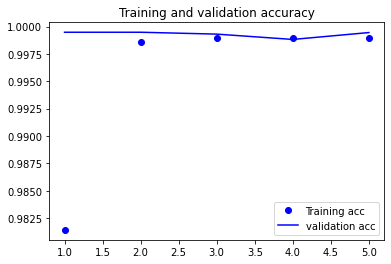

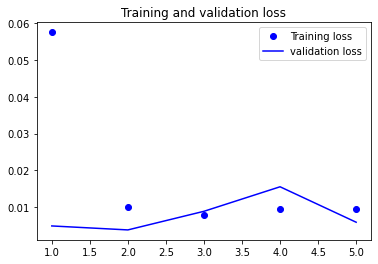

[0.004944443702697754, 0.003866282757371664, 0.00892201904207468, 0.015575990080833435, 0.005954076535999775]
5
0.9994564056396484 4
Epoch 1/5
1231/1231 [==============================] - 655s 532ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 0.0178 - val_accuracy: 0.9985
Epoch 2/5
1231/1231 [==============================] - 650s 528ms/step - loss: 0.0084 - accuracy: 0.9991 - val_loss: 0.0106 - val_accuracy: 0.9990
Epoch 3/5
1231/1231 [==============================] - 639s 519ms/step - loss: 0.0073 - accuracy: 0.9992 - val_loss: 0.0057 - val_accuracy: 0.9995
Epoch 4/5
1231/1231 [==============================] - 651s 529ms/step - loss: 0.0091 - accuracy: 0.9991 - val_loss: 0.0062 - val_accuracy: 0.9995
Epoch 5/5
1231/1231 [==============================] - 645s 524ms/step - loss: 0.0092 - accuracy: 0.9991 - val_loss: 0.0063 - val_accuracy: 0.9995

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1}
(1451, 1)
(148451, 1)
(1451, 50,

In [4]:
train_and_test('Fuzzy_train_final.csv','Fuzzy_test_final.csv','Fuzzy_final.h5')

In [4]:
# 训练并确定模型，并保存
# 训练过程结果可不输出
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
from keras.layers import LSTM, Dense, Activation,Input,core,Dropout
from keras.models import Model
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# 读取CSV数据集，并拆分为训练集和测试集
# 该函数的传入参数为CSV_FILE_PATH: csv文件路径

def TP(y_true,y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    return TP

def TN(y_true,y_pred):
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    return TN

def FP(y_true,y_pred):
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    return FP

def FN(y_true,y_pred):
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    return FN

class LossHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

def load_data(CSV_FILE_PATH, size1, size2):
    CAN = pd.read_csv(CSV_FILE_PATH)
    target_var = 'class'  # 目标变量
    # 数据集的特征
    features = list(CAN.columns)
    features.remove(target_var)
    features.remove('id_dis')
    # 目标变量的类别
    Class = CAN[target_var].unique()
    # 目标变量的类别字典
    Class_dict = dict(zip(Class, range(len(Class))))
    # 增加一列target, 将目标变量进行编码
    CAN['target'] = CAN[target_var].apply(lambda x: Class_dict[x])
    # 对目标变量进行0-1编码(One-hot Encoding)
    lb = LabelBinarizer()
    lb.fit(list(Class_dict.values()))
    transformed_labels = lb.transform(CAN['target'])
    y_bin_labels = []  # 对多分类进行0-1编码的变量
    for i in range(transformed_labels.shape[1]):
        y_bin_labels.append('y' + str(i))
        CAN['y' + str(i)] = transformed_labels[:, i]
    # 将数据集分为训练集和验证集
    train_x, val_x, train_y, val_y = train_test_split(CAN[features], CAN[y_bin_labels], \
                                                        train_size=size1, test_size=size2, shuffle=False, random_state=0) # shuffle=True, stratify=None
    print(type(Class_dict))
    print(Class_dict)
    return train_x, val_x, train_y, val_y, Class_dict

def train_and_test_mul(file1,file2,model1):
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file1
    train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #val_x = val_x.values.reshape(val_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    val_y=val_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(val_y.shape)
    train_x = series_to_supervised(train_x, 49)
    val_x = series_to_supervised(val_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    val_x = val_x.values.reshape(val_x.shape[0],50,16)
    print(val_x.shape)


    # 2. 定义模型
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = K.optimizers.Adam()
    model = K.models.Sequential()
    model.add(LSTM(units=256,input_shape=(50, 16),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
    model.add(Dense(4,activation='tanh'))
    #model.add(Activation('tanh'))
    #model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
    #model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
    #model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
    #rmsprop = RMSprop(lr=0.01)
    #model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    #print(model.summary())
    # 3. 训练模型
    b_size = 256
    max_epochs = 2
    # max_epochs = 2
    history = LossHistory()
    print("Starting training ")
    h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))

    # 展示训练结果
    import matplotlib.pyplot as plt
    acc = h.history['accuracy']
    loss = h.history['loss']
    val_acc = h.history['val_accuracy']
    val_loss = h.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    # 根据验证集最小损失确定迭代轮数，确定并保存模型
    print(val_loss)
    print(len(val_loss))
    min_num = val_loss[0]
    min_index = 0
    for i in range(len(val_loss)):
        if val_loss[i] < min_num:
            min_num = val_acc[i]
            min_index = i

    print(min_num,min_index)

    h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
    model.save(model1)

    # 测试，展示测试结果
    # 为了和网站匹配及展示的方便，使用刚刚保存的模型
    from keras.models import load_model
    # 0. 开始
    print("\nCAN dataset using Keras/TensorFlow ")
    np.random.seed(4)
    tf.random.set_seed(13)

    # 1. 读取CSV数据集
    print("Loading CAN data into memory")
    CSV_FILE_PATH = file2
    train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
    #train_x = train_x.values.reshape(train_x.shape[0],1,16)
    #test_x = test_x.values.reshape(test_x.shape[0],1,16)
    train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                                31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
    print(train_y.shape)
    test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                       train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                           train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                           train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                           train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                           train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                           train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                           train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                           train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                           train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
    print(test_y.shape)
    train_x = series_to_supervised(train_x, 49)
    test_x = series_to_supervised(test_x, 49)
    train_x = train_x.values.reshape(train_x.shape[0],50,16)
    print(train_x.shape)
    test_x = test_x.values.reshape(test_x.shape[0],50,16)
    print(test_x.shape)


    # 加载刚刚保存的模型
    final_model = load_model(model1)
    # 测试模型的结果
    eval2 = final_model.evaluate(test_x, test_y, verbose=0)
    print('测试集上的loss和acc：')
    print(eval2)

    # 详细评估指标
    predictions = final_model.predict(test_x)
    from sklearn.metrics import classification_report
    print(classification_report(test_y.values, np.int64(predictions > 0.5),digits=4))

    # 混淆矩阵
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(test_y, np.int64(predictions > 0.5)))


CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
(809951, 4)
(89951, 4)
(809951, 50, 16)
(89951, 50, 16)
Starting training 
Epoch 1/2
3164/3164 [==============================] - 2175s 687ms/step - loss: 0.0160 - accuracy: 0.9917 - val_loss: 5.4250e-04 - val_accuracy: 0.9999
Epoch 2/2
3164/3164 [==============================] - 1867s 590ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 0.9997


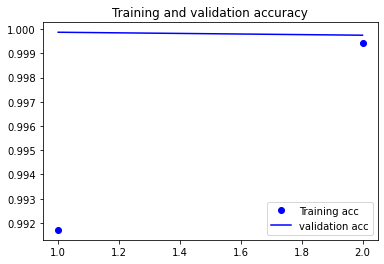

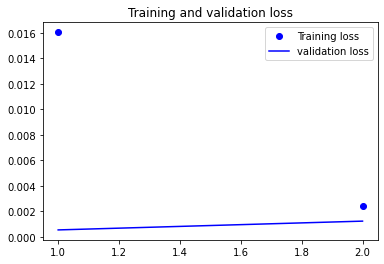

[0.0005425020935945213, 0.0012307579163461924]
2
0.0005425020935945213 0
3164/3164 [==============================] - 1863s 589ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 7.3607e-06 - val_accuracy: 1.0000

CAN dataset using Keras/TensorFlow 
Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
(2951, 4)
(296951, 4)
(2951, 50, 16)
(296951, 50, 16)
测试集上的loss和acc：
[0.0008332447614520788, 0.9998114109039307]


D:\1_OtherSoftware\miniconda\MiniConda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999    247347
           1     0.9995    0.9968    0.9981     15303
           2     0.9999    1.0000    0.9999     18228
           3     1.0000    0.9999    1.0000     16073

   micro avg     0.9998    0.9998    0.9998    296951
   macro avg     0.9998    0.9992    0.9995    296951
weighted avg     0.9998    0.9998    0.9998    296951
 samples avg     0.9998    0.9998    0.9998    296951



ValueError: multilabel-indicator is not supported

In [8]:
train_and_test_mul('multiply_train_final.csv','multiply_test_final.csv','multiply_final.h5')

In [2]:
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

file1='multiply_train_final.csv'
file2='multiply_test_final.csv'
model1='multiply_final.h5'
# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = file1
train_x, val_x, train_y, val_y, Class_dict = load_data(CSV_FILE_PATH, 0.9, 0.1)
#train_x = train_x.values.reshape(train_x.shape[0],1,16)
#val_x = val_x.values.reshape(val_x.shape[0],1,16)
train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                            31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
print(train_y.shape)
val_y=val_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                   train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                       train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                       train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                       train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                       train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                       train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                       train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                       train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                       train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
print(val_y.shape)
train_x = series_to_supervised(train_x, 49)
val_x = series_to_supervised(val_x, 49)
train_x = train_x.values.reshape(train_x.shape[0],50,16)
print(train_x.shape)
val_x = val_x.values.reshape(val_x.shape[0],50,16)
print(val_x.shape)


# 2. 定义模型
init = K.initializers.glorot_uniform(seed=1)
simple_adam = K.optimizers.Adam()
model = K.models.Sequential()
model.add(LSTM(units=256,input_shape=(50, 16),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, kernel_initializer=init, activation='linear'))
model.add(Dense(4,activation='tanh'))
#model.add(Activation('tanh'))
#model.add(K.layers.Dense(units=6, kernel_initializer=init, activation='relu'))
#model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='sigmoid'))
#model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])'''
#rmsprop = RMSprop(lr=0.01)
#model.compile(loss='mae', optimizer='rmsprop', metrics=['accuracy',TP,TN,FP,FN])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#print(model.summary())
# 3. 训练模型
b_size = 256
max_epochs = 1
# max_epochs = 2
history = LossHistory()
print("Starting training ")
h = model.fit(train_x, train_y, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))

# 展示训练结果
import matplotlib.pyplot as plt
acc = h.history['accuracy']
loss = h.history['loss']
val_acc = h.history['val_accuracy']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 根据验证集最小损失确定迭代轮数，确定并保存模型
print(val_loss)
print(len(val_loss))
min_num = val_loss[0]
min_index = 0
for i in range(len(val_loss)):
    if val_loss[i] < min_num:
        min_num = val_acc[i]
        min_index = i

print(min_num,min_index)

h = model.fit(train_x, train_y, batch_size=b_size, epochs=min_index+1, shuffle=True, verbose=1,callbacks=[history], validation_data=(val_x, val_y))
model.save(model1)

# 测试，展示测试结果
# 为了和网站匹配及展示的方便，使用刚刚保存的模型
from keras.models import load_model
# 0. 开始
print("\nCAN dataset using Keras/TensorFlow ")
np.random.seed(4)
tf.random.set_seed(13)

# 1. 读取CSV数据集
print("Loading CAN data into memory")
CSV_FILE_PATH = file2
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
#train_x = train_x.values.reshape(train_x.shape[0],1,16)
#test_x = test_x.values.reshape(test_x.shape[0],1,16)
train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                            31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
print(train_y.shape)
test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                   train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                       train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                       train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                       train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                       train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                       train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                       train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                       train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                       train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
print(test_y.shape)
train_x = series_to_supervised(train_x, 49)
test_x = series_to_supervised(test_x, 49)
train_x = train_x.values.reshape(train_x.shape[0],50,16)
print(train_x.shape)
test_x = test_x.values.reshape(test_x.shape[0],50,16)
print(test_x.shape)


# 加载刚刚保存的模型
final_model = load_model(model1)
# 测试模型的结果
eval2 = final_model.evaluate(test_x, test_y, verbose=0)
print('测试集上的loss和acc：')
print(eval2)

# 详细评估指标
predictions = final_model.predict(test_x)
from sklearn.metrics import classification_report
print(classification_report(test_y.values, np.int64(predictions > 0.25),digits=4))

# 混淆矩阵
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_y, np.int64(predictions > 0.25)))


CAN dataset using Keras/TensorFlow 


NameError: name 'np' is not defined

In [7]:
predictions[1300:1400]

array([[ 0.99996555, -0.99168485, -0.99992657, -0.9999543 ],
       [ 0.9999863 , -0.9938584 , -0.9999596 , -0.99998295],
       [ 0.9999905 , -0.9948601 , -0.99997103, -0.99998856],
       [ 0.9999974 , -0.996768  , -0.99998844, -0.99999636],
       [ 0.99999475, -0.9961192 , -0.9999777 , -0.9999934 ],
       [ 0.9998235 , -0.9869195 , -0.9997311 , -0.9998257 ],
       [-0.97998244,  0.9999133 , -0.9989278 , -0.9930377 ],
       [-0.99438626,  0.9999955 , -0.99978054, -0.99658316],
       [-0.9940923 ,  0.99999535, -0.9998271 , -0.9949346 ],
       [-0.99368036,  0.99999493, -0.9998802 , -0.99241346],
       [ 0.9999785 , -0.99124646, -0.99993384, -0.99997574],
       [-0.9806738 ,  0.99995744, -0.99973464, -0.98858404],
       [ 0.9999564 , -0.9859353 , -0.99994624, -0.999957  ],
       [ 0.9999928 , -0.99421984, -0.99997437, -0.9999931 ],
       [ 0.9999872 , -0.9934505 , -0.99996775, -0.999983  ],
       [ 0.99999106, -0.99456006, -0.9999685 , -0.99998945],
       [-0.97915554,  0.

In [7]:
from keras.models import load_model
print("Loading CAN data into memory")
CSV_FILE_PATH = 'multiply_test_final.csv'
train_x, test_x, train_y, test_y, Class_dict = load_data(CSV_FILE_PATH, 0.01, 0.99)
#train_x = train_x.values.reshape(train_x.shape[0],1,16)
#test_x = test_x.values.reshape(test_x.shape[0],1,16)
train_y=train_y.drop(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                            31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
print(train_y.shape)
test_y=test_y.drop(index=[train_x.shape[0]+0,train_x.shape[0]+1,train_x.shape[0]+2,train_x.shape[0]+3,train_x.shape[0]+4,
                   train_x.shape[0]+5,train_x.shape[0]+6,train_x.shape[0]+7,train_x.shape[0]+8,train_x.shape[0]+9,train_x.shape[0]+10,
                       train_x.shape[0]+11,train_x.shape[0]+12,train_x.shape[0]+13,train_x.shape[0]+14,train_x.shape[0]+15,
                       train_x.shape[0]+16,train_x.shape[0]+17,train_x.shape[0]+18,train_x.shape[0]+19,train_x.shape[0]+20,
                       train_x.shape[0]+21,train_x.shape[0]+22,train_x.shape[0]+23,train_x.shape[0]+24,train_x.shape[0]+25,
                       train_x.shape[0]+26,train_x.shape[0]+27,train_x.shape[0]+28,train_x.shape[0]+29,train_x.shape[0]+30,
                       train_x.shape[0]+31,train_x.shape[0]+32,train_x.shape[0]+33,train_x.shape[0]+34,train_x.shape[0]+35,
                       train_x.shape[0]+36,train_x.shape[0]+37,train_x.shape[0]+38,train_x.shape[0]+39,train_x.shape[0]+40,
                       train_x.shape[0]+41,train_x.shape[0]+42,train_x.shape[0]+43,train_x.shape[0]+44,train_x.shape[0]+45,
                       train_x.shape[0]+46,train_x.shape[0]+47,train_x.shape[0]+48])
print(test_y.shape)
train_x = series_to_supervised(train_x, 49)
test_x = series_to_supervised(test_x, 49)
train_x = train_x.values.reshape(train_x.shape[0],50,16)
print(train_x.shape)
test_x = test_x.values.reshape(test_x.shape[0],50,16)
print(test_x.shape)


# 加载刚刚保存的模型
final_model = load_model('multiply_final.h5')
# 测试模型的结果
eval2 = final_model.evaluate(test_x, test_y, verbose=0)
print('测试集上的loss和acc：')
print(eval2)
predictions = final_model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)

Loading CAN data into memory
<class 'dict'>
{'T0': 0, 'T1': 1, 'T2': 2, 'T3': 3}
(2951, 4)
(296951, 4)
(2951, 50, 16)
(296951, 50, 16)
测试集上的loss和acc：
[0.0009024450555443764, 0.9997979402542114]


NameError: name 'model' is not defined

In [8]:
from keras.models import load_model
predictions = final_model.predict(test_x)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))
print(confusion_matrix)

<function confusion_matrix at 0x00000204E1BAFEE8>


In [10]:
confusion_matrix(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1))

array([[247336,     10,      1,      0],
       [    39,  15264,      0,      0],
       [     0,      0,  18228,      0],
       [     9,      0,      1,  16063]], dtype=int64)

In [25]:
predictions[103000:104000].argmax(axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,

In [27]:
test_y[103000:104000].values.argmax(axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,

In [30]:
from sklearn.metrics import classification_report
print(classification_report(test_y.values.argmax(axis=-1), predictions.argmax(axis=-1),digits=4))

              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999    247347
           1     0.9993    0.9975    0.9984     15303
           2     0.9999    1.0000    0.9999     18228
           3     1.0000    0.9994    0.9997     16073

    accuracy                         0.9998    296951
   macro avg     0.9998    0.9992    0.9995    296951
weighted avg     0.9998    0.9998    0.9998    296951

